<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

In [3]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

%matplotlib inline
plt.style.use("fivethirtyeight")

## 1.1. Подготовка данных (1 балл)


In [3]:
def fetch_dataset(
    attrs_name = "lfw_attributes.txt",
    images_name = "lfw-deepfunneled",
    dx=80, dy=80,
    dimx=64, dimy=64
):
    #read attrs
    df_attrs = pd.read_csv(attrs_name, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs, photo_ids, on=('person','imagenum'))

    assert len(df) == len(df_attrs), "lost some data when merging dataframes"

    all_photos = df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [9]:
from typing import Literal

from torch.utils.data import Dataset, DataLoader

type ModeType = Literal['train','valid','test']
# доступно только в python 3.12.0+


class DatasetPhoto(Dataset):

    def __init__(self, photos: np.ndarray, mode: ModeType):
        super().__init__()
        self.photos = photos

        if mode == 'train':
            self.transformers = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)
            ])
        else:
            self.transformers = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True)
            ])

    def __len__(self):
        return len(self.photos)
        
    def __getitem__(self, index: int):
        photo = self.photos[index]
        photo = self.transformers(photo)

        return photo


In [5]:
data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data, test_size=0.3, shuffle=True)
X_valid, X_test = train_test_split(X_test, test_size=0.5, shuffle=True)

train_dataset = DatasetPhoto(X_train, 'train')
valid_dataset = DatasetPhoto(X_valid, 'valid')
test_dataset = DatasetPhoto(X_test, 'test')

In [7]:
def dt_generator(dt: DatasetPhoto, batch: int = 16, random: bool = True):
    length = len(dt)
    if random:
      indexs = np.random.permutation(length)
    else:
       indexs = range(length)
    count_iter = length // batch

    for i in range(count_iter):
        last_index = min((i+1) * batch, length-1)
        photos = []
        for indx in indexs[i*batch:last_index]:
            photo = dt[indx]
            photos.append(photo)
        yield torch.stack(photos)

In [65]:
transform = v2.ToPILImage()
def show_photo(photos):
    count = len(photos)
    fig, axs = plt.subplots(1, count)
    fig.set_figwidth(count * 3)
    fig.set_figheight(6)

    for i, photo in enumerate(photos):
        axs[i].imshow(transform(photo))
        axs[i].axis("off")
    
    plt.show()

# photos = next(iter(dt_generator(train_dataset, 10)))
# show_photo(photos)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [9]:
from pathlib import Path


class AbstractModule(nn.Module):
    name: str

    def save(self, path: Path):
        """Сохраняет модель"""
        torch.save(
            self.state_dict(),
            path.joinpath("model"),
        )
        with open(path.joinpath("struct.txt"), "+w") as file:
            file.write(str(self))

    def get_count_params(self):
        return sum(p.numel() for p in self.parameters())

    @classmethod
    def load(cls, dim_code: int, mode: str, path: str):
        model = cls(dim_code, mode)
        model.load_state_dict(torch.load(path, weights_only=True))
        model.eval()
        return model


In [15]:
class ConvBlock(nn.Module):
    def __init__(self, inp, out, mode: Literal["encoder", "decoder"]):
        super().__init__()
        self.act = nn.ReLU()

        mid = (inp + out) // 2
        self.conv1 = nn.Conv2d(inp, inp, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(inp)
        self.conv2 = nn.Conv2d(inp, out, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(out)
        # self.conv3 = nn.Conv2d(out, out, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(out)

        match mode:
            case "encoder":
                # self.pool = nn.MaxPool2d(2)
                self.pool = nn.Conv2d(out, out, kernel_size=3, stride=2, padding=1)
            case "decoder":
                # self.pool = nn.Upsample(scale_factor=2)
                self.pool = nn.ConvTranspose2d(
                    out, out, kernel_size=3, stride=2, padding=1, output_padding=1
                )

    def forward(self, x):
        out = self.act(self.norm1(self.conv1(x)))
        out = self.act(self.norm2(self.conv2(out)))
        # out = self.act(self.norm3(self.conv3(out)))
        out = self.pool(out)
        return out


class Autoencoder(AbstractModule):
    def __init__(self, dim_code: int, mode: Literal["conv", "fully"]):
        super().__init__()
        self.name = f"AE_{mode}"
        match mode:
            case "conv":
                self.encoder = nn.Sequential(
                    ConvBlock(3, 8, "encoder"),
                    ConvBlock(8, 16, "encoder"),
                    ConvBlock(16, 32, "encoder"),
                    nn.Flatten(),
                    nn.Linear(8 * 8 * 32, dim_code),
                )

                self.decoder = nn.Sequential(
                    nn.Linear(dim_code, 8 * 8 * 32),
                    nn.Unflatten(1, (32, 8, 8)),
                    ConvBlock(32, 16, "decoder"),
                    ConvBlock(16, 8, "decoder"),
                    ConvBlock(8, 3, "decoder"),
                    nn.Conv2d(3, 3, 1),
                    nn.Sigmoid(),
                )
            case "fully":
                self.encoder = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(12288, 512),
                    nn.BatchNorm1d(512),
                    nn.LeakyReLU(3e-3),
                    nn.Linear(512, 256),
                    nn.BatchNorm1d(256),
                    nn.LeakyReLU(3e-3),
                    nn.Linear(256, dim_code),
                )

                self.decoder = nn.Sequential(
                    nn.Linear(dim_code, 256),
                    nn.BatchNorm1d(256),
                    nn.LeakyReLU(3e-3),
                    nn.Linear(256, 512),
                    nn.BatchNorm1d(512),
                    nn.LeakyReLU(3e-3),
                    nn.Linear(512, 12288),
                    nn.Unflatten(1, (3, 64, 64)),
                    nn.Sigmoid(),
                )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)

        return reconstruction, latent_code


In [11]:
DIM_CODE = 128 # выберите размер латентного вектора
COUNT_EPOCH = 40
STEP_SIZE = 10
BATCH_SIZE = 16
DEVICE = 'cpu' if torch.cuda.is_available() else 'cpu'

AE_conv = Autoencoder(DIM_CODE, 'conv').to(DEVICE)
AE_fully = Autoencoder(DIM_CODE,'fully').to(DEVICE)

In [99]:
params_conv = list(AE_conv.parameters())
params_fully = list(AE_fully.parameters())

count_params_conv = len(params_conv[0].flatten()) * len(params_conv)
count_params_fully = len(params_fully[0].flatten()) * len(params_fully)

print(f"Количество параметров:\nConv - {count_params_conv};\nFully - {count_params_fully};")
multiply_params = count_params_fully // count_params_conv
print(f"\nВ FullyAE параметров в {multiply_params} раз больше, чем в ConvAE!")

Количество параметров:
Conv - 6318;
Fully - 125829120;

В FullyAE параметров в 19915 раз больше, чем в ConvAE!


## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [ ]:
from tqdm import tqdm


def train(
    model: nn.Module,
    dl_train: DatasetPhoto,
    dl_valid: DatasetPhoto,
    loss_fn: nn.modules.loss._WeightedLoss,
    optimizer: optim.Optimizer,
    epoch: int,
    scheduler=None
):
  history = {
    'train': [],
    'valid': []
  }

  train_total = round(len(dl_train)/BATCH_SIZE)
  valid_total = round(len(dl_valid)/BATCH_SIZE)
  for i in range(epoch):
    print(f"Epoch: {i+1}")

    model.train()
    train_loss = 0
    for input in tqdm(dt_generator(dl_train), total=train_total, desc='train'):
      input = input.to(DEVICE)
      optimizer.zero_grad()
      predict, _ = model(input)
      loss = loss_fn(predict, input)
      loss.backward()
      optimizer.step()

      if scheduler is not None:
        scheduler.step()
      
      train_loss += loss.detach().cpu().item()

    train_loss /= train_total
    history['train'].append(train_loss)

    model.eval()
    valid_loss = 0
    for input in tqdm(dt_generator(dl_valid, random=False), total=valid_total, desc='valid'):
      input = input.to(DEVICE)
      with torch.no_grad():
        predict, _ = model(input)
        loss = loss_fn(predict, input)

      valid_loss += loss.detach().cpu().item()

    valid_loss /= valid_total
    history['valid'].append(valid_loss)

    show_photo(input)
    show_photo(predict.permute(0,2,3,1))
    print(f'Loss train: {train_loss}')
    print(f'Loss valid: {valid_loss}')

  return history

In [101]:
loss_fn = nn.MSELoss().to(DEVICE)
optimizer = optim.Adam(AE_conv.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)
model = Autoencoder(DIM_CODE, 'conv')
# history = train(model, train_dataset, valid_dataset, loss_fn, optimizer, COUNT_EPOCH, scheduler)

---
**Мысли автора**

Обучение в ноутбуке очень медленное, поэтому обучал в обычном .py-файле

---

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [102]:
model = Autoencoder(DIM_CODE, 'conv').to(DEVICE)
model.load_state_dict(torch.load('models/AE_conv/30-11-2024_21-16/model', weights_only=True))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): ConvBlock(
      (act): ReLU()
      (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): ConvBlock(
      (act): ReLU()
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nor

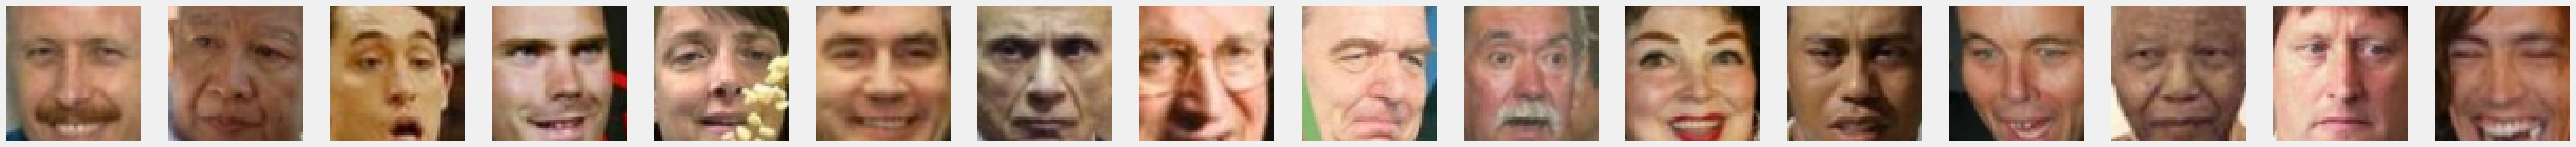

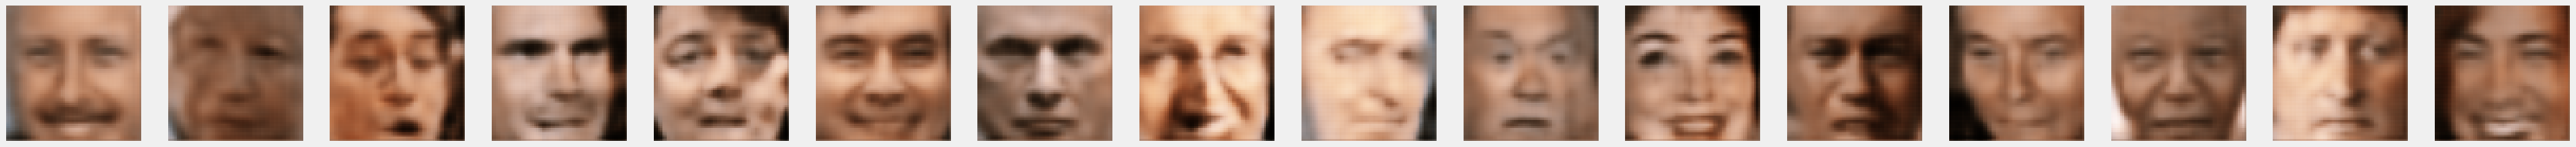

In [103]:
img = next(iter(dt_generator(test_dataset)))
pred, _ = model(img.to(DEVICE))


show_photo(img)
show_photo(pred)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

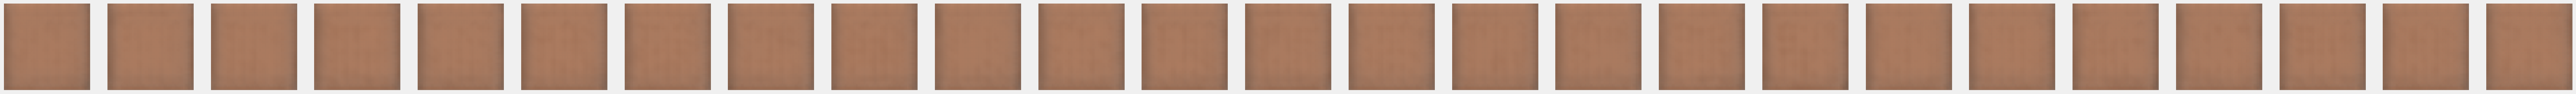

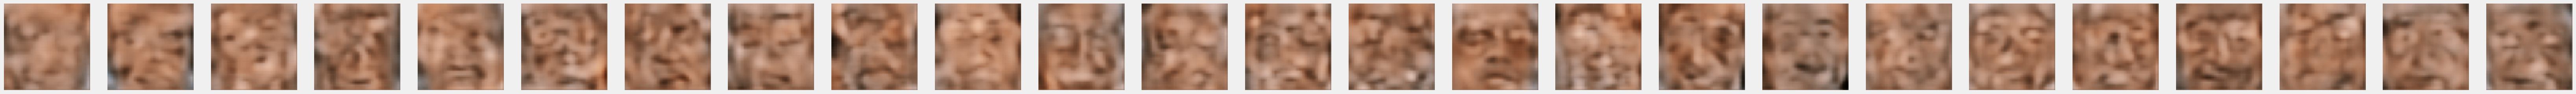

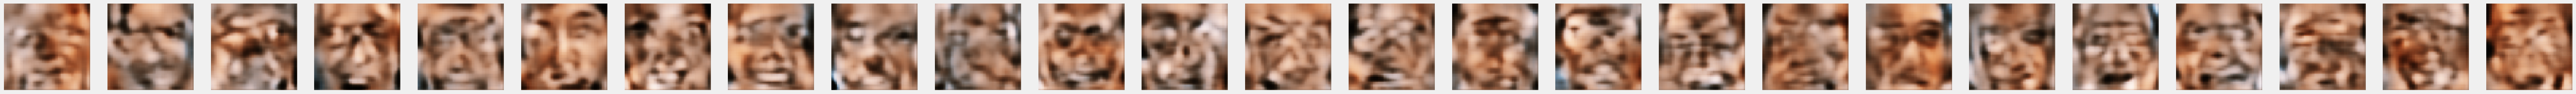

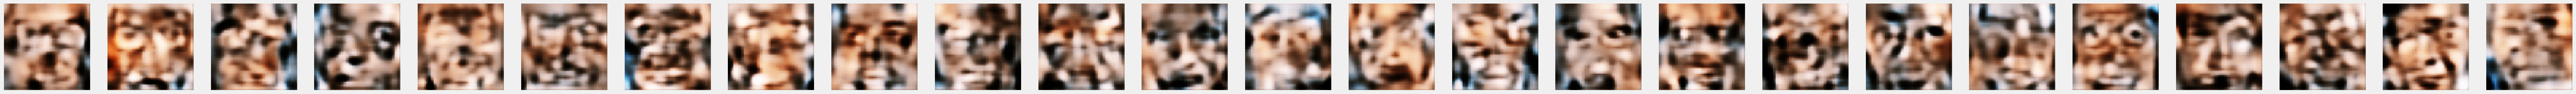

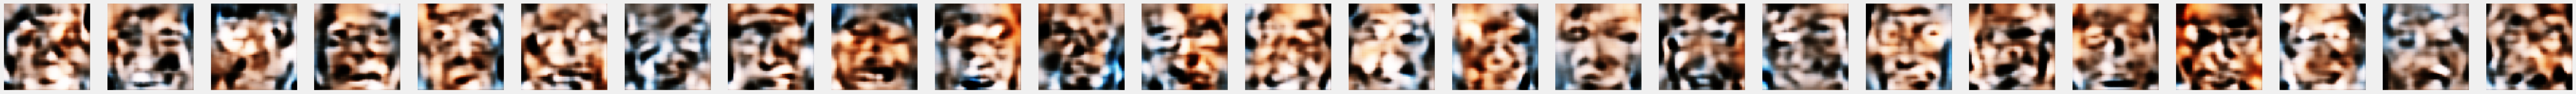

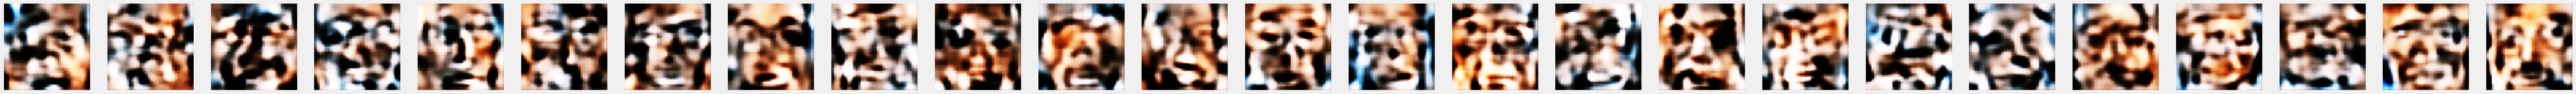

In [104]:
# сгенерируем 25 рандомных векторов размера latent_space

for latent_scale in range(1, 120, 20):
    z = latent_scale * np.random.randn(25, DIM_CODE).astype(np.float32)
    transform_t = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32)])
    zt = transform_t(z)[0]

    output = model.decoder(zt)
    show_photo(output)

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [148]:
COUNT_SMILING = 25
happy_index = attrs[attrs.Smiling > 2].sample(COUNT_SMILING).index
sad_index = attrs[attrs.Smiling < -2].sample(COUNT_SMILING).index

In [149]:
happy_photo = [data[indx] for indx in happy_index]
sad_photo = [data[indx] for indx in sad_index]

happy_dt = DatasetPhoto(happy_photo, mode='test')
sad_dt = DatasetPhoto(sad_photo, mode='test')

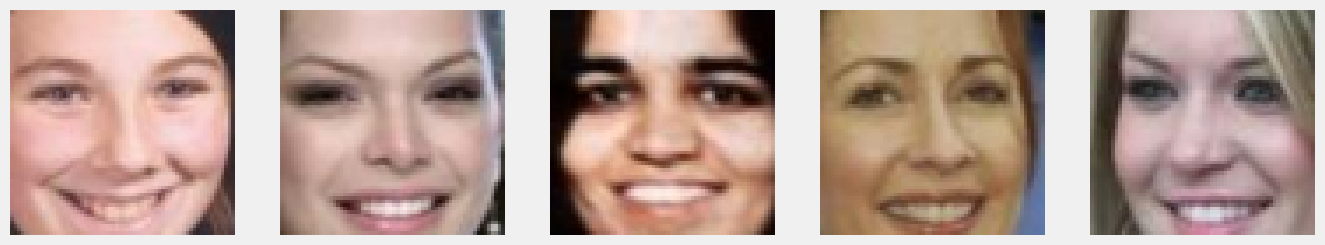

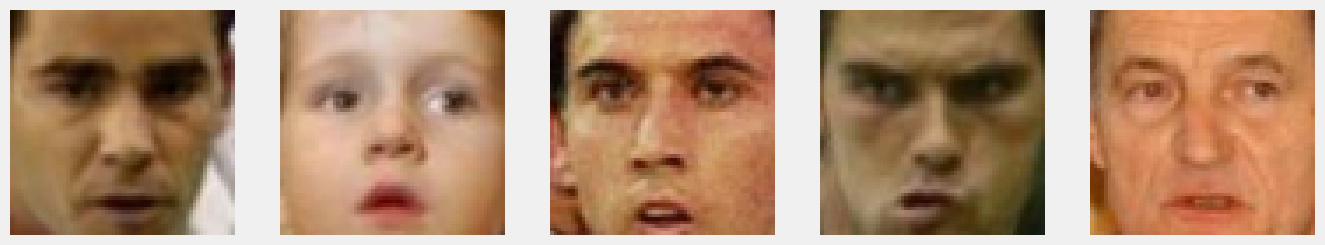

In [150]:
photos_h = next(iter(dt_generator(happy_dt, 5)))
photos_s = next(iter(dt_generator(sad_dt, 5)))
show_photo(photos_h)
show_photo(photos_s)

In [151]:
happy_latent = []
sad_latent = []

happy_dt_photos = torch.stack([photo for photo in happy_dt])
sad_dt_photos = torch.stack([photo for photo in sad_dt])
_, happy_latent = model(happy_dt_photos)
_, sad_latent = model(sad_dt_photos)

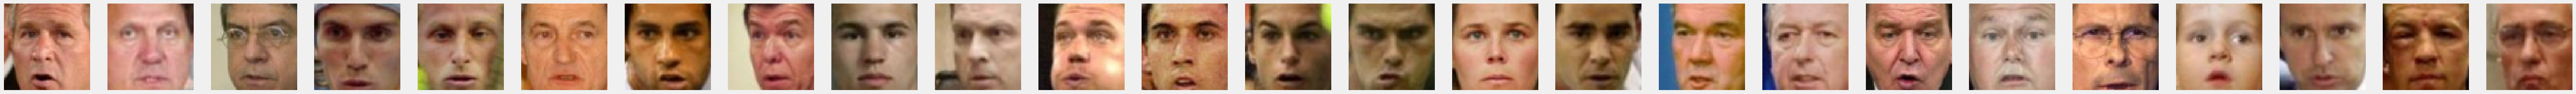

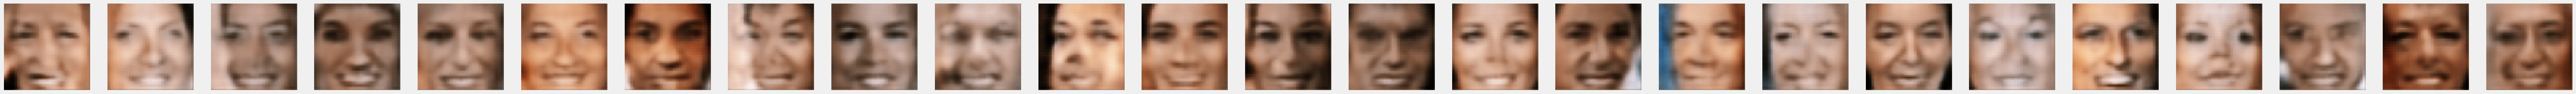

In [152]:
happy_happy_latent = happy_latent.mean(0) - sad_latent.mean(0)
fix_latent = sad_latent + happy_happy_latent
outp = model.decoder(fix_latent)

show_photo(sad_dt_photos)
show_photo(outp)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [4]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=v2.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=v2.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

d:\Code\Python\ML\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [58]:
class PrintLayer(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x


class VAE(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*4*4, dim*2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim, 64*4*4),
            nn.Unflatten(1, (64,4,4)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )


    def encode(self, x):
        out = self.encoder(x)
        mu, logsigma = torch.tensor_split(out, 2, dim=1)

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5*logsigma)
            eps = torch.rand_like(mu)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logsigma = self.encode(x)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample)
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [59]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = - 1/2 * torch.sum((1 + logsigma - mu**2 - torch.exp(logsigma)))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

И обучим модель:

In [60]:
DIM_CODE_2 = 16
EPOCHS = 10
DEVICE = 'cpu' if torch.cuda.is_available() else 'cpu'
loss_fn = loss_vae
autoencoder = VAE(DIM_CODE_2)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)

In [61]:
from tqdm import tqdm

def train(
    model: nn.Module,
    dl_train: DataLoader,
    dl_valid: DataLoader,
    loss_fn: nn.modules.loss._WeightedLoss,
    optimizer: optim.Optimizer,
    epoch: int,
    scheduler=None
):
  history = {
    'train': [],
    'valid': []
  }

  for i in range(epoch):
    print(f"Epoch: {i+1}")

    model.train()
    train_loss = 0
    for input, _ in tqdm(dl_train, desc='train'):
      input = input.to(DEVICE)
      optimizer.zero_grad()
      mu, logsigma, reconstruction = model(input)
      loss = loss_fn(input, mu, logsigma, reconstruction)

      loss.backward()
      optimizer.step()

      if scheduler is not None:
        scheduler.step()

      train_loss += loss.detach().cpu().item()

    train_loss /= len(dl_train)
    history['train'].append(train_loss)

    model.eval()
    valid_loss = 0
    for input, _ in tqdm(dl_valid, desc='valid'):
      input = input.to(DEVICE)
      with torch.no_grad():
        mu, logsigma, reconstruction = model(input)
        loss = loss_fn(input, mu, logsigma, reconstruction)

      valid_loss += loss.detach().cpu().item()

    valid_loss /= len(dl_valid)
    history['valid'].append(valid_loss)

    print(f'Loss train: {train_loss}')
    print(f'Loss valid: {valid_loss}')

  return history

In [62]:
history = train(autoencoder, train_loader, test_loader, loss_fn, optimizer, EPOCHS)

Epoch: 1


valid: 100%|██████████| 313/313 [00:02<00:00, 144.04it/s]


Loss train: 3886.250543098958
Loss valid: 3632.367412140575
Epoch: 2


valid: 100%|██████████| 313/313 [00:02<00:00, 126.36it/s]


Loss train: 3029.8029006510415
Loss valid: 3373.973130881215
Epoch: 3


valid: 100%|██████████| 313/313 [00:02<00:00, 134.62it/s]


Loss train: 2937.3173376302084
Loss valid: 3199.0230506190096
Epoch: 4


valid: 100%|██████████| 313/313 [00:02<00:00, 150.23it/s]


Loss train: 2887.9898264322915
Loss valid: 3180.4683635090105
Epoch: 5


valid: 100%|██████████| 313/313 [00:02<00:00, 150.64it/s]


Loss train: 2857.270103515625
Loss valid: 3101.8049601106977
Epoch: 6


valid: 100%|██████████| 313/313 [00:02<00:00, 152.16it/s]


Loss train: 2833.5391389322917
Loss valid: 3082.0247514133634
Epoch: 7


valid: 100%|██████████| 313/313 [00:02<00:00, 144.04it/s]


Loss train: 2815.953395052083
Loss valid: 3038.9163521958617
Epoch: 8


valid: 100%|██████████| 313/313 [00:01<00:00, 160.59it/s]


Loss train: 2802.089653515625
Loss valid: 3071.868655463758
Epoch: 9


valid: 100%|██████████| 313/313 [00:02<00:00, 149.40it/s]


Loss train: 2789.8686186197915
Loss valid: 3091.117226890101
Epoch: 10


valid: 100%|██████████| 313/313 [00:02<00:00, 131.18it/s]

Loss train: 2779.149544921875
Loss valid: 2993.7044034232727


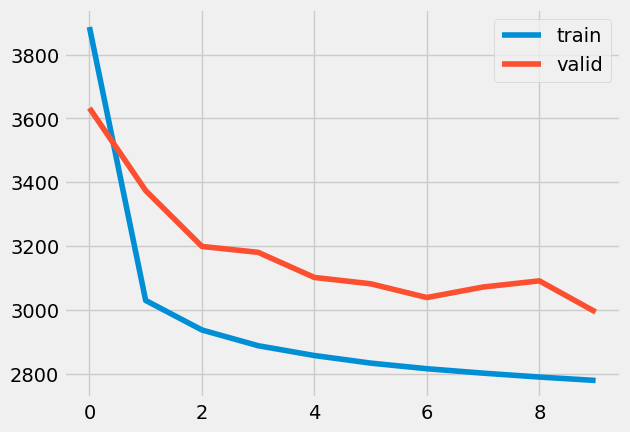

In [75]:
plt.plot(history['train'], label='train')
plt.plot(history['valid'], label='valid')
plt.legend()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

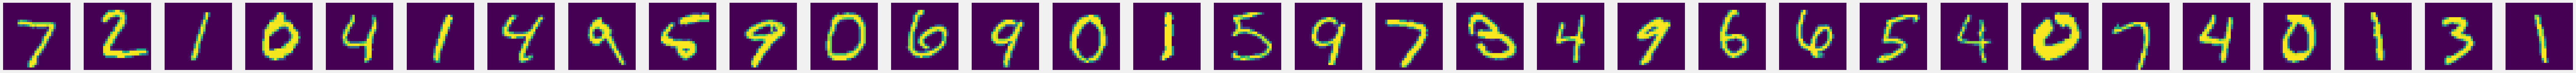

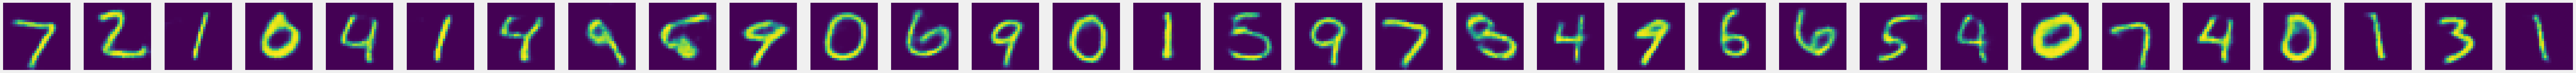

In [66]:
input, _ = next(iter(test_loader))
_, _, reconstruction = autoencoder(input)
show_photo(input)
show_photo(reconstruction)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

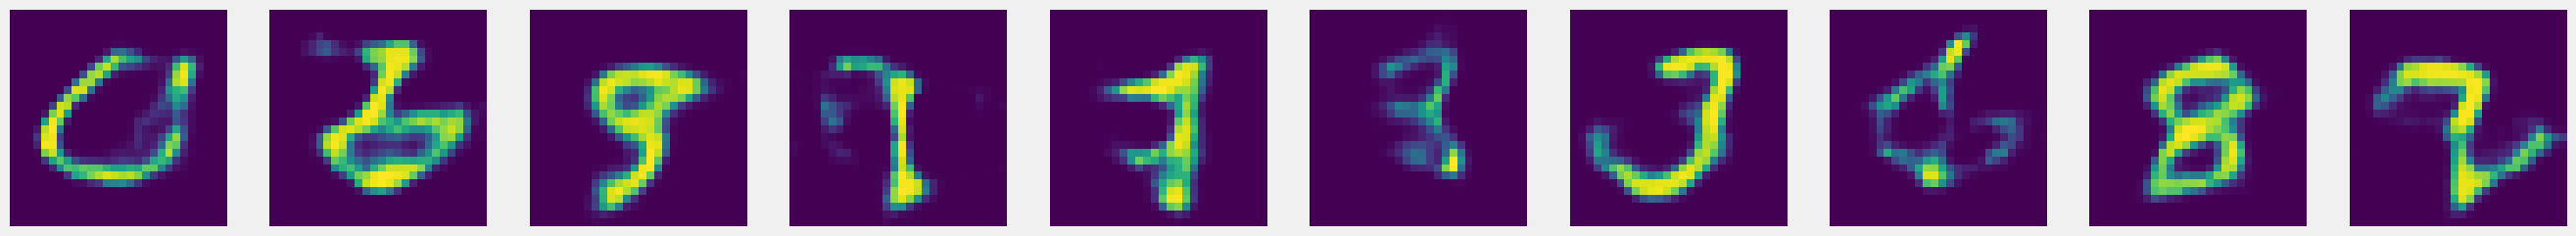

In [70]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, DIM_CODE_2) for i in range(10)])
output = autoencoder.decode(torch.tensor(z, dtype=torch.float32))
show_photo(output)

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [71]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
latents = []
labels = []

for input, output in test_loader:
    labels.append(output)
    mu, logsigma = autoencoder.encode(input)
    latent = autoencoder.gaussian_sampler(mu, logsigma)
    latents.append(latent)

In [72]:
coords = tsne.fit_transform(torch.cat(latents).detach().numpy())

In [73]:
labels = torch.cat(labels)
x, y = zip(*coords)

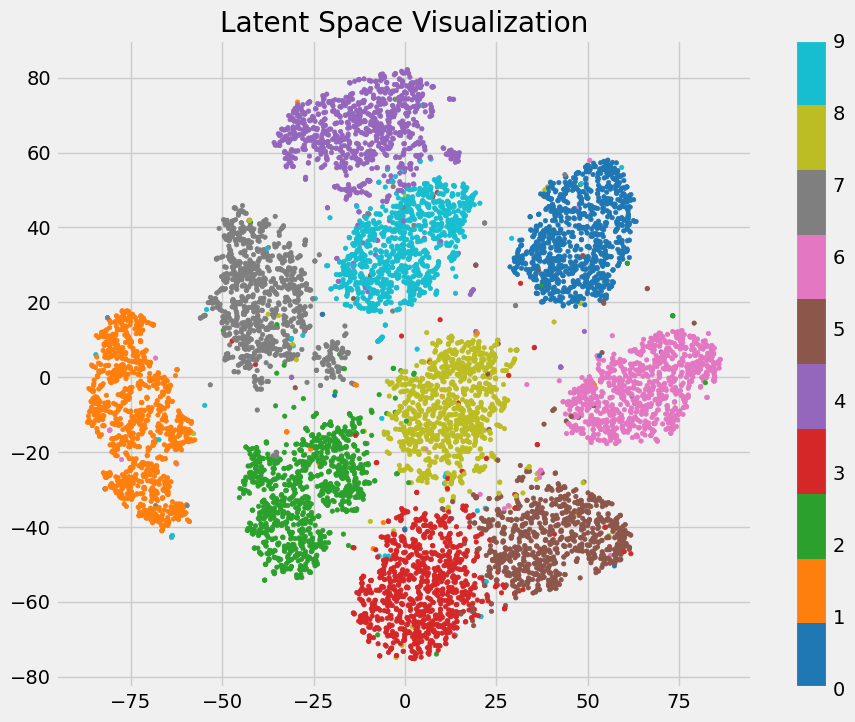

In [74]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x, y, c=labels, cmap='tab10', s=10)
plt.colorbar(scatter)
plt.title("Latent Space Visualization")
plt.show()

Что вы думаете о виде латентного представления?

---
**Мысли автора**

В целом пойдет)

---

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [376]:
from sklearn.preprocessing import OneHotEncoder


class CVAE(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.one_hot = OneHotEncoder()
        self.one_hot.fit_transform([[i] for i in range(10)])

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*7*7, dim*2),
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim+10, 16*7*7),
            nn.Unflatten(1, (16,7,7)),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x, class_num):
        outp = self.encoder(x)
        mu, logsigma = torch.tensor_split(outp, 2, dim=1)
        class_num = self.one_hot.transform([[i] for i in class_num]).toarray()
        return mu, logsigma, torch.tensor(class_num, dtype=torch.float32)

    def gaussian_sampler(self, mu: float, logsigma: float):
        if self.training:
            std = torch.exp(0.5 * logsigma)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z, class_num):
        inp = torch.cat([z, class_num], dim=1)
        reconstruction = self.decoder(inp)

        return reconstruction

    def forward(self, x, class_num: list[int]):
        mu, logsigma, class_num = self.encode(x, class_num)
        sample = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(sample, class_num)
        return mu, logsigma, reconstruction

In [380]:
def train(
    model: nn.Module,
    dl_train: DataLoader,
    dl_valid: DataLoader,
    loss_fn: nn.modules.loss._WeightedLoss,
    optimizer: optim.Optimizer,
    epoch: int,
    scheduler=None
):
  history = {
    'train': [],
    'valid': []
  }

  for i in range(epoch):
    print(f"Epoch: {i+1}")

    model.train()
    train_loss = 0
    for input, label in tqdm(dl_train, desc='train'):
      input = input.to(DEVICE)
      optimizer.zero_grad()
      mu, logsigma, reconstruction = model(input, label)
      loss = loss_fn(input, mu, logsigma, reconstruction)

      loss.backward()
      optimizer.step()

      if scheduler is not None:
        scheduler.step()

      train_loss += loss.detach().cpu().item()

    train_loss /= len(dl_train)
    history['train'].append(train_loss)

    model.eval()
    valid_loss = 0
    for input, label in tqdm(dl_valid, desc='valid'):
      input = input.to(DEVICE)
      with torch.no_grad():
        mu, logsigma, reconstruction = model(input, label)
        loss = loss_fn(input, mu, logsigma, reconstruction)

      valid_loss += loss.detach().cpu().item()

    valid_loss /= len(dl_valid)
    history['valid'].append(valid_loss)

    print(f'Loss train: {train_loss}')
    print(f'Loss valid: {valid_loss}')

  return history

In [381]:
EPOCHS = 10
loss_fn = loss_vae
cautoencoder = CVAE(DIM_CODE_2)
optimizer = optim.Adam(cautoencoder.parameters(), lr=1e-3)

In [382]:
history = train(cautoencoder, train_loader, test_loader, loss_fn, optimizer, EPOCHS)

Epoch: 1


valid: 100%|██████████| 313/313 [00:02<00:00, 144.04it/s]


Loss train: 5278.889660416667
Loss valid: 4320.357917176268
Epoch: 2


valid: 100%|██████████| 313/313 [00:02<00:00, 156.19it/s]


Loss train: 4330.061527473958
Loss valid: 4104.6282420783
Epoch: 3


valid: 100%|██████████| 313/313 [00:02<00:00, 143.91it/s]


Loss train: 4163.056150520833
Loss valid: 3987.090103100664
Epoch: 4


valid: 100%|██████████| 313/313 [00:04<00:00, 68.56it/s] 


Loss train: 4077.9484052083335
Loss valid: 3929.087641024361
Epoch: 5


valid: 100%|██████████| 313/313 [00:02<00:00, 118.22it/s]


Loss train: 4034.5046052083335
Loss valid: 3912.513148883661
Epoch: 6


valid: 100%|██████████| 313/313 [00:02<00:00, 112.55it/s]


Loss train: 4003.842609765625
Loss valid: 3872.3739302272616
Epoch: 7


valid: 100%|██████████| 313/313 [00:02<00:00, 114.11it/s]


Loss train: 3984.500538671875
Loss valid: 3856.760436816718
Epoch: 8


valid: 100%|██████████| 313/313 [00:02<00:00, 134.59it/s]


Loss train: 3967.2941470052083
Loss valid: 3845.6745773169177
Epoch: 9


valid: 100%|██████████| 313/313 [00:04<00:00, 65.10it/s] 


Loss train: 3953.9169912760417
Loss valid: 3837.9050694669777
Epoch: 10


valid: 100%|██████████| 313/313 [00:02<00:00, 124.01it/s]

Loss train: 3942.5289055989583
Loss valid: 3824.305596592327


### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

4


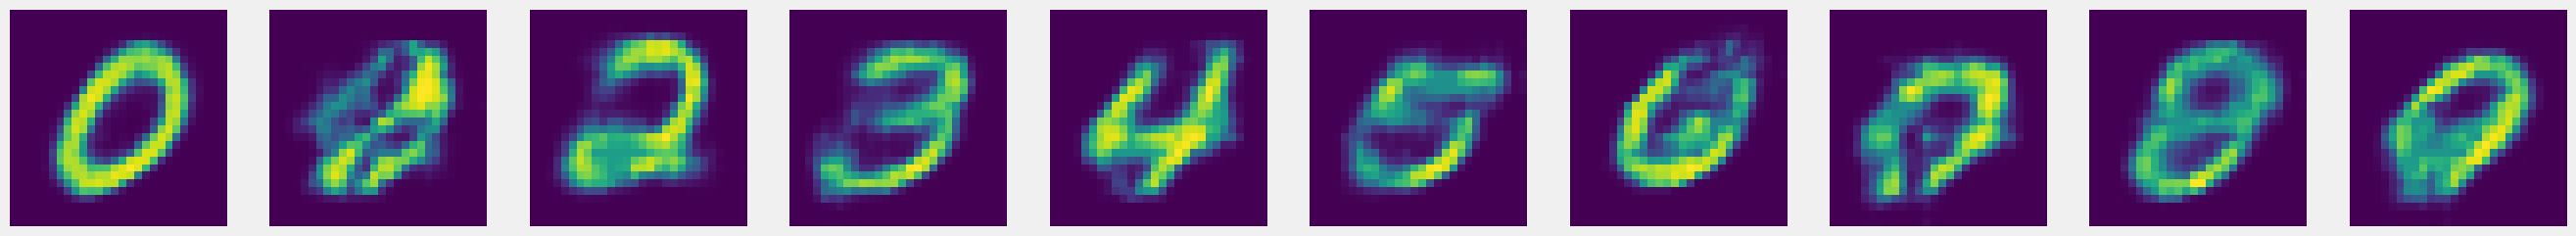

In [398]:
input, label = train_dataset[np.random.randint(0, len(train_dataset))]
inputs = torch.stack([input for _ in range(10)])

_, _, outputs = cautoencoder(inputs, list(range(10)))
print(label)
show_photo(outputs)

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [400]:
tsne = TSNE(n_components=2)

latents = []
labels = []

for input, label in test_loader:
    labels.append(label)
    mu, logsigma, class_name = cautoencoder.encode(input, label)
    sample = cautoencoder.gaussian_sampler(mu, logsigma)
    latents.append(torch.cat([class_name, sample], dim=1))

In [405]:
coords = tsne.fit_transform(torch.cat(latents).detach().numpy())

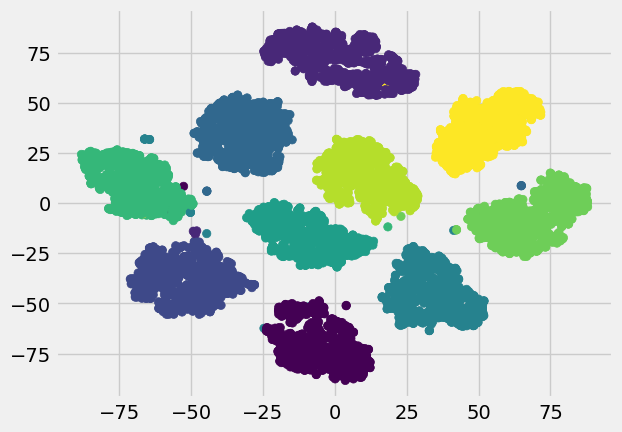

In [ ]:
x, y = zip(*coords)
c = torch.cat(labels)
plt.scatter(x, y, c=c)

In [ ]:
def plot_latent_space_cvae(cvae, val_loader, device):
    cvae.eval()

    latent_vectors = []
    labels = []

    # Получаем латентные представления для всех изображений в тестовом датасете
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # Получаем латентное представление (mu) с учетом меток классов
            z_mu, _ = cvae.encode(X_batch, Y_batch)

            latent_vectors.append(z_mu.cpu().numpy())
            labels.append(Y_batch.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Сжимаем латентные векторы до 2D пространства с помощью t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Визуализируем 2D представления с использованием matplotlib
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=10)
    plt.colorbar(scatter, label="Class")
    plt.title("Latent Space Visualization for CVAE")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()

# Вызываем функцию для визуализации
plot_latent_space_cvae(cvae, test_loader, device)


Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

---
**Мысли автора**

Эстетическое наслажедние

---

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [18]:
model = Autoencoder(128, 'conv')
model.load_state_dict(torch.load('models/AE_conv/03-12-2024_10-37/model', weights_only=True))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): ConvBlock(
      (act): ReLU()
      (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (norm3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): ConvBlock(
      (act): ReLU()
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nor

---
**Мысли автора**

Обучал в файле .py

---

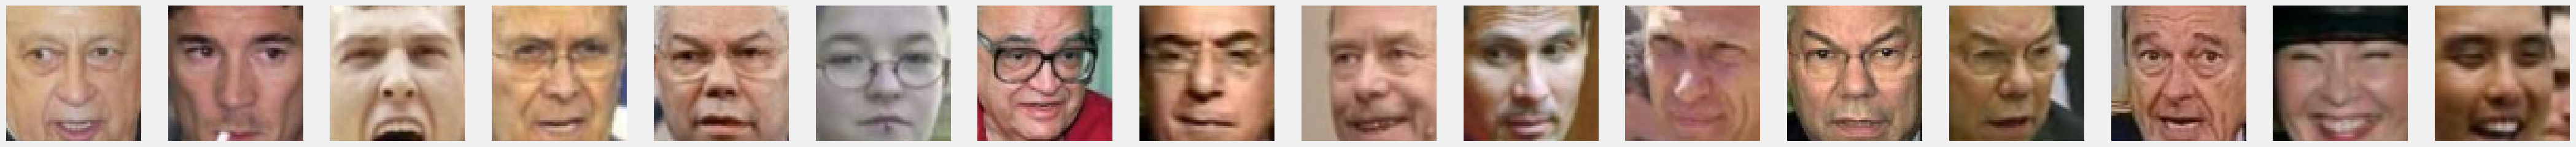

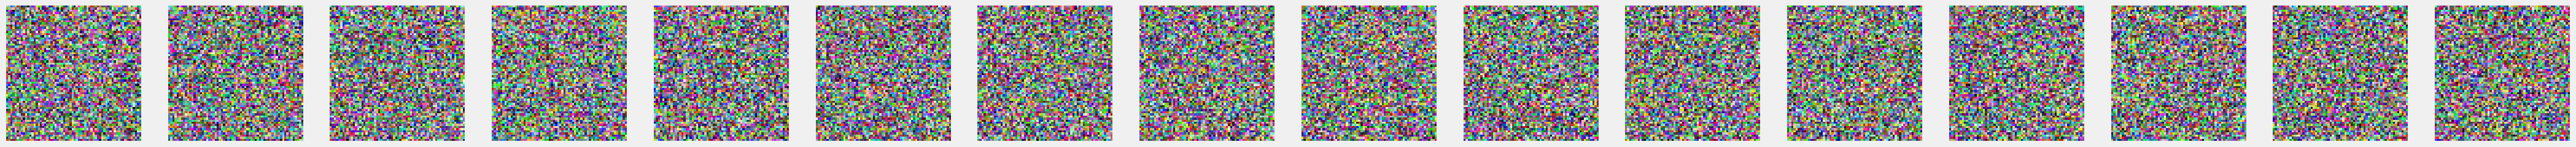

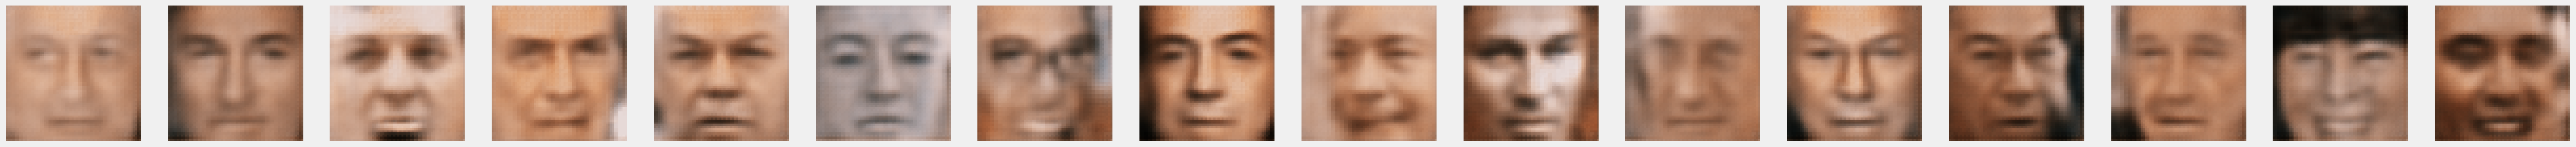

In [20]:
NOISE_FACTOR = 0.5
img = next(iter(dt_generator(test_dataset)))
noised_inputs = img + NOISE_FACTOR * torch.normal(0, 1, size=img.shape)
pred, _ = model(noised_inputs)


show_photo(img)
show_photo(noised_inputs)
show_photo(pred)

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>